
# AI2 - Assignment 4 - SQuAD - QA - BERT

__Student's Credentials__: Vissarion Moutafis - sdi1800119

In this notebook we will fine tune *DistilBERT* model, on SQuAD dataset. We will use **exact match** and **soft f1 score** as evaluation metrics and we will provide the user with a routing that answers questions based on a context.


### Loading Hugging Face
To start with, we will import utilities and download the dataset from transformers library

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn
import re
seaborn.set_style("ticks")

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, classification_report

import nltk
from nltk.stem.snowball import SnowballStemmer 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download("stopwords")
nltk.download("wordnet")

import torch
import torch.nn as nn
import torchtext
from torch.utils.data import SubsetRandomSampler
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

!pip install transformers datasets
import transformers
import datasets
from transformers import BertTokenizer, BertForSequenceClassification, AutoModelForSequenceClassification, AutoModelForQuestionAnswering
from datasets import load_dataset, load_metric

!pip install tqdm
from tqdm import tqdm, trange

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
     |████████████████████████████████| 311 kB 624 kB/s            
     |████████████████████████████████| 212 kB 9.1 MB/s            
cuda:0


In [2]:
model_checkpoint = 'bert-base-uncased'

In [3]:
dataset = load_dataset('squad_v2')

Downloading:   0%|          | 0.00/1.87k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/9.55M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/801k [00:00<?, ?B/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset squad_v2 downloaded and prepared to /root/.cache/huggingface/datasets/squad_v2/squad_v2/2.0.0/09187c73c1b837c95d9a249cd97c2c3f1cebada06efe667b4427714b27639b1d. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

After that we will need a tokenizer. We will use the default *bistil-bert-uncased* tokenizer instance from transformers library.

In [4]:
from transformers import AutoTokenizer
# initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
MAX_LENGTH = 384
DOC_STRIDE = 128 # multi-context overlapping range for large context'd instances 

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

To preprocess the data we will:
- concat the query and the context
- tokenize the context and the query 
- use overflow mappings to enable multi context answers, since there might be answers that overflow the context tokens' length
- use offset mapping to get start and end positions of answer in tokenized input

In [5]:
def preprocess_squad(examples):
  # get the questions and the context
  questions = [q.strip() for q in examples["question"]]
  context = examples["context"]
  # tokenize questions along with the context 
  inputs = tokenizer(
        questions,
        context,
        max_length=MAX_LENGTH,
        stride=DOC_STRIDE,
        truncation="only_second",
        padding="max_length",
        return_offsets_mapping=True,
        return_overflowing_tokens=True
    )
  offset_mapping = inputs.pop("offset_mapping")
  sample_mapping = inputs.pop("overflow_to_sample_mapping")
  answers = examples["answers"]
  start_positions = []
  end_positions = []
  
  for i, offset in enumerate(offset_mapping):
    sample_index = sample_mapping[i]
    answer = examples["answers"][sample_index]
    # if there is no answer default to [CLS]
    if not answer["answer_start"]:
      start_positions.append(inputs['input_ids'][i].index(tokenizer.cls_token_id))
      end_positions.append(inputs['input_ids'][i].index(tokenizer.cls_token_id))
      continue 
    
    # get answer start and end positions
    start_char = answer["answer_start"][0]
    end_char = answer["answer_start"][0] + len(answer["text"][0])
    sequence_ids = inputs.sequence_ids(i)

    # Find the start and end of the context
    idx = 0
    while sequence_ids[idx] != 1:
      idx += 1
    context_start = idx
    while sequence_ids[idx] == 1:
      idx += 1
    context_end = idx - 1

    # If the answer is not fully inside the context, label it (0, 0)
    if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
#       start_positions.append(inputs['input_ids'][i].index(tokenizer.cls_token_id))
#       end_positions.append(inputs['input_ids'][i].index(tokenizer.cls_token_id))
      start_positions.append(-1)
      end_positions.append(-1)
    else:
      # Otherwise it's the start and end token positions
      idx = context_start
      while idx <= context_end and offset[idx][0] <= start_char:
        idx += 1
      start_positions.append(idx - 1)

      idx = context_end
      while idx >= context_start and offset[idx][1] >= end_char:
        idx -= 1
      end_positions.append(idx + 1)

  inputs["start_positions"] = start_positions
  inputs["end_positions"] = end_positions
  return inputs


Map the whole dataset and define train/test datasets and data loaders.

In [6]:
dataset = dataset.map(preprocess_squad, batched=True, remove_columns=dataset['train'].column_names)


  0%|          | 0/131 [00:00<?, ?ba/s]

  0%|          | 0/12 [00:00<?, ?ba/s]

Remove the questions that have an answer, but it is not in the context-split they are assigned to. They have start and end pos equal to -1

In [7]:
def is_valid(s, e):
    return s != -1 and e != -1

dataset = dataset.filter(is_valid, input_columns=['start_positions', 'end_positions'])

  0%|          | 0/132 [00:00<?, ?ba/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

In [8]:
train_dataset = dataset['train']
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=24, shuffle=True)

In [9]:
test_dataset = dataset['validation']
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=24, shuffle=True)

## Model Creation

We will use the default checkpoint model from transformers library and train it for 2 epochs in order to fine tune it on SQuAD.v2 dataset

In [10]:
torch.cuda.empty_cache()

In [11]:
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased a

In [12]:
model = model.to(device)

In [13]:
def training_step(model, optimizer, epoch_i, train_loader, history=None):
  torch.cuda.empty_cache()
  # 1 step of backprop with train/test error estimation
  total_loss = 0
  acc = []
  pbar = tqdm(train_loader)
  for i,batch in enumerate(pbar):
    torch.cuda.empty_cache()
    # set the gradients to zero for new estimation
    optimizer.zero_grad() 
    # forward pass
    args = {
        "start_positions" : torch.LongTensor(batch["start_positions"]).to(device),
        "end_positions" : torch.LongTensor(batch["end_positions"]).to(device),
        "input_ids" : torch.stack(batch["input_ids"], axis=1).to(device),
        "attention_mask" : torch.stack(batch["attention_mask"], axis=1).to(device),
    }
    outputs = model(**args) 
    loss = outputs[0]
    start_pred = torch.argmax(outputs['start_logits'], dim=1)
    end_pred = torch.argmax(outputs['end_logits'], dim=1)
    # compute loss 
    total_loss += loss.item()

    # backpropagate error
    loss.backward()
    # apply gradient clipping adjust model's parameters
    torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
    optimizer.step()
    
    acc.append(((start_pred == args['start_positions']).sum()/len(start_pred)).item())
    acc.append(((end_pred == args['end_positions']).sum()/len(end_pred)).item())
    pbar.set_description('Epoch {}: train loss: {}, train accuracy: {}%'.format(epoch_i, total_loss/(i+1), sum(acc)/len(acc)), refresh=True)
    
  train_loss = total_loss/len(train_loader)
    
    # if the user provides with a history dict the training step will save the current epoch's train-test loss
  if history is not None: 
    history['train'].append(train_loss)
  
  test_loss = 0
  acc = []
  pbar = tqdm(test_loader)
  for i,batch in enumerate(pbar):
    torch.cuda.empty_cache()
    with torch.no_grad():
      args = {
          "start_positions" : torch.LongTensor(batch["start_positions"]).to(device),
          "end_positions" : torch.LongTensor(batch["end_positions"]).to(device),
          "input_ids" : torch.stack(batch["input_ids"], axis=1).to(device),
          "attention_mask" : torch.stack(batch["attention_mask"], axis=1).to(device)
        }
      outputs = model(**args)
      test_loss += outputs[0].item()
      start_pred = torch.argmax(outputs['start_logits'], dim=1)
      end_pred = torch.argmax(outputs['end_logits'], dim=1)
      acc.append(((start_pred == args['start_positions']).sum()/len(start_pred)).item())
      acc.append(((end_pred == args['end_positions']).sum()/len(end_pred)).item())
      pbar.set_description('Epoch {}: test loss {}%, test accuracy {}%'.format(epoch_i, test_loss/(i+1), sum(acc)/len(acc)), refresh=True)
        
  if history is not None: 
    history['test'].append(test_loss/len(test_loader))
    

  
  return train_loss, test_loss/len(test_loader), sum(acc)/len(acc)

def train_model(history, model, train_loader, epochs, _lr):
  # set to training mode
  model.train()
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.AdamW(model.parameters(), lr = _lr)

  for epoch in range(epochs):
    training_step(model, optimizer, epoch, train_loader, history)


In [14]:
history = {'train':[], 'test':[]}
train_model(history, model, train_loader, 2,  3e-5)

Epoch 0: train loss: 1.3639209815324882, train accuracy: 0.5876470924027591%: 100%|██████████| 5460/5460 [2:05:59<00:00,  1.38s/it]
Epoch 0: test loss 1.213103824521441%, test accuracy 0.6244743440552537%: 100%|██████████| 502/502 [03:08<00:00,  2.66it/s]
Epoch 1: train loss: 0.8246920993653956, train accuracy: 0.736978319123551%: 100%|██████████| 5460/5460 [2:06:20<00:00,  1.39s/it]
Epoch 1: test loss 1.1384754116791653%, test accuracy 0.6615759372948651%: 100%|██████████| 502/502 [03:08<00:00,  2.67it/s]


## Evaluation

We will print the evaluation stats (metrics and training loss curves) for our model. After that we will provide the QA routine.

In [15]:
model.eval()

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

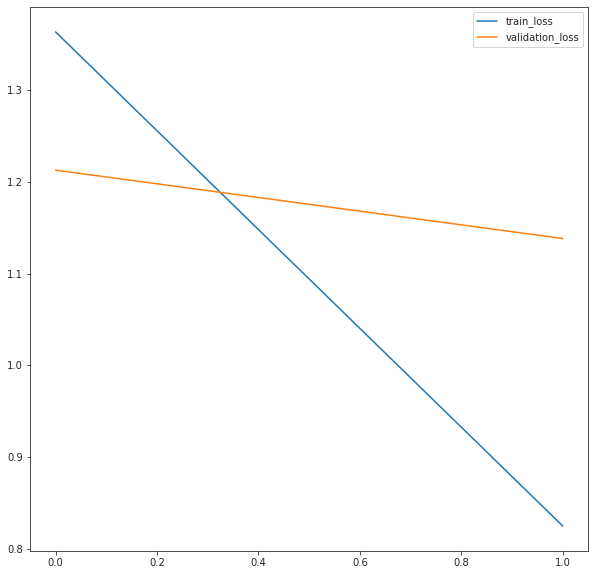

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
train_loss = history['train']
test_loss = history['test']
ax.plot(np.arange(len(train_loss)), train_loss, test_loss)
ax.legend(['train_loss', 'validation_loss'])

In [17]:
# compute exact match based on identity opretion for torch.Tensor
def compute_exact_match(prediction, truth):
    return (torch.LongTensor([prediction[i][0] == truth[i][0] and prediction[i][1] == truth[i][1] for i in range(len(truth))]).sum()/len(truth)).item()

# compute soft f1 score based on calculating common tokens ocurrences 
def compute_f1(pred_token_ranges, truth_token_ranges):
    tmp_f1 = []
    for i in range(pred_token_ranges.shape[0]):
      start_p, end_p = int(pred_token_ranges[i][0]), int(pred_token_ranges[i][1])
      start_t, end_t = int(true_token_ranges[i][0]), int(true_token_ranges[i][1])
      common_tokens = max(min(end_t, end_p) - max(start_t, start_p) + 1, 0)
      if common_tokens == 0:
        tmp_f1.append(0)
        continue
      prec = common_tokens / (end_p - start_p + 1)
      rec = common_tokens / (end_t - start_t + 1)
      tmp_f1.append(2 * (prec * rec) / (prec + rec))
    return sum(tmp_f1)/len(tmp_f1)

In [18]:
f1_total = []
acc = []
test_loss = []
acc = []
pbar = tqdm(test_loader)
for batch in pbar:
  torch.cuda.empty_cache()
  with torch.no_grad():
    args = {
          "start_positions" : torch.LongTensor(batch["start_positions"]).to(device),
          "end_positions" : torch.LongTensor(batch["end_positions"]).to(device),
          "input_ids" : torch.stack(batch["input_ids"], axis=1).to(device),
          "attention_mask" : torch.stack(batch["attention_mask"], axis=1).to(device)
        }
    outputs = model(**args)
    test_loss.append(outputs[0].item())
    # find the indices for start and end in every example of the batch
    start_positions = []
    end_positions = []
    start_pred = torch.argmax(outputs['start_logits'], dim=1)
    end_pred = torch.argmax(outputs['end_logits'], dim=1)
    
    # create token ranges in the form of (start, end) and calculate f1 score
    pred_token_ranges = torch.stack((start_pred, end_pred), axis=1)
    true_token_ranges = torch.stack((args['start_positions'], args['end_positions']), axis=1)
    # calculate exact match
    acc.append(compute_exact_match(pred_token_ranges, true_token_ranges))
    
    f1_total.append(compute_f1(pred_token_ranges, true_token_ranges))
    pbar.set_description('Test loss {}, test accuracy {}, F1-Score={}'.format(sum(test_loss)/len(test_loss), round(sum(acc)/len(acc), 2), round(np.mean(f1_total),2)), refresh=True)

Test loss 1.1291144053299589, test accuracy 0.62, F1-Score=0.69: 100%|██████████| 502/502 [03:01<00:00,  2.77it/s]


In [19]:
# if you want to load your own model do it here (useful after first training session, 2h long)
# model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)
# model.to(device)

## The Question Answer Routine

Following we give a routine that a user can answer queries based on a context. All you have to do is provide with a context and a question and we are ready to go.

In [20]:
def answer_q(question, context):
    # tokenize question and context
    inputs = tokenizer(
      question,
      context,
      max_length=MAX_LENGTH,
      stride=DOC_STRIDE,
      truncation="only_second",
      padding="max_length",
      return_overflowing_tokens=True
    )
    
    # predict answer
    args = {
          "input_ids" : torch.LongTensor(inputs["input_ids"]).to(device),
          "attention_mask" : torch.LongTensor(inputs["attention_mask"]).to(device)
      }
    outputs = model(**args)
    
    # acquire the answer with the highest
    position_scores = {}
    context_idx = inputs.sequence_ids().index(1)
    for start_pos, start_conf in enumerate(outputs['start_logits'][0][context_idx:].reshape(-1).detach().tolist()):
        for end_pos, end_conf in enumerate(outputs['end_logits'][0][context_idx:].reshape(-1).detach().tolist()):
            position_scores[start_pos+context_idx, end_pos+context_idx] = start_conf+end_conf
            
    start_pos, end_pos = max(position_scores.keys(), key=lambda p : position_scores[p])
    
    answer = tokenizer.decode(inputs['input_ids'][0][start_pos:end_pos+1])
    if answer == '[CLS]' or answer == '':
        answer = 'Impossible to answer.'
    answer = answer.replace('[CLS]', '')
    answer = answer.replace('[SEP]', '')

    return answer

In [21]:
context = 'BERT has its origins from pre-training contextual representations including semi-supervised sequence learning,[14] generative pre-training, ELMo,[15] and ULMFit.[16] Unlike previous models, BERT is a deeply bidirectional, unsupervised language representation, pre-trained using only a plain text corpus. Context-free models such as word2vec or GloVe generate a single word embedding representation for each word in the vocabulary, where BERT takes into account the context for each occurrence of a given word. For instance, whereas the vector for "running" will have the same word2vec vector representation for both of its occurrences in the sentences "He is running a company" and "He is running a marathon", BERT will provide a contextualized embedding that will be different according to the sentence.'
questions = ['What are BERT\'origins?', 
             'What is BERT?', 
             'How context free models deal with words?', 
             'What\'s your favorite desert?']
for q in questions:
    print(f'Question: {q}\nAnswer: {answer_q(q, context)}\n')

Question: What are BERT'origins?
Answer: pre - training contextual representations

Question: What is BERT?
Answer: pre - training contextual representations

Question: How context free models deal with words?
Answer: a single word embedding representation

Question: What's your favorite desert?
Answer: ulmfit



In [22]:
context = 'James Patrick Page OBE (born 9 January 1944)[1][2] \n \
is an English musician, songwriter, multi-instrumentalist and \n \
record producer who achieved international success as the guitarist and founder of the rock band Led Zeppelin. '
q = 'For what band, did Page play for?'
print(f'Question: {q}\nAnswer: {answer_q(q, context)}\n')
q = 'What is Page\' full-name?'
print(f'Question: {q}\nAnswer: {answer_q(q, context)}\n')
q = 'When was Page born?'
print(f'Question: {q}\nAnswer: {answer_q(q, context)}\n')

Question: For what band, did Page play for?
Answer: led zeppelin

Question: What is Page' full-name?
Answer: james patrick page obe

Question: When was Page born?
Answer: 9 january 1944



## Save the model

In [23]:
model.save_pretrained('./bert-finetune-squad2', private=True)